## Introduction to Pytorch and Neural Networks




In [1]:
#useful imports

import numpy as np
from numpy.random import randint,rand,seed,normal,permutation
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

from torchvision.datasets import MNIST
import torchvision.transforms as T


from keras.datasets import mnist
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm

from scipy.special import softmax



In [2]:
def show_performance_curves(training_loss,validation_loss,training_accuracy,validation_accuracy,test_accuracy):

    plt.figure(figsize=(5, 3))
    plt.plot(training_loss,label='Training',color='g')
    plt.plot(validation_loss,label='Validation',color='b')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
#     plt.ylim(-0.1,(max(max(training_loss),max(validation_loss))*1.1) )
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    
    print('Final Training Loss:  ',np.around(training_loss[-1],6))
    print('Final Validation Loss:',np.around(validation_loss[-1],6))
    
    plt.figure(figsize=(5, 3))
    plt.plot(training_accuracy,label='Training',color='g')
    plt.plot(validation_accuracy,label='Validation',color='b')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
#     plt.ylim(-0.1,1.1)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    
    print('Final Training Accuracy:  ',np.around(training_accuracy[-1],6))
    print('Final Validation Accuracy:',np.around(validation_accuracy[-1],6))
    print()
    
    print("Test Accuracy:", test_accuracy.item())
    print()

In [3]:
from sklearn.datasets import make_blobs

# Generate sample data
n_samples = 1000
n_components = 4
c_std = 0.5

# watchout: make_blobs returns float64 but torch uses float32 by default

X_blobs1, Y_blobs1 = make_blobs(n_samples=n_samples, centers=n_components, cluster_std=c_std,random_state=0)

# Watch out: make_blobs returns float64 but torch uses float32 by default
#            nn.CrossEntropyLoss() expects long ints

X_blobs = torch.tensor(X_blobs1).float()
Y_blobs = torch.tensor(Y_blobs1).long()                  


## The Data:  Blobs!

For this first example of a neural network, we are going to use a simple dataset
created by `make_blobs` from `sklearn`. 

The data will consist of 1000 pairs of numbers $(x,y)$ in a grid, separated into 4 different groups, with labels 0, 1, 2, 3. We will build a simple NN to learn these groups. 

In [4]:
# let's look at the data a bit

print(X_blobs.size(),'\n')
print(Y_blobs.size(),'\n')
print(X_blobs[:5],'\n')
print(Y_blobs[:5],'\n')

print('     Point Coordinates    ','\tGroup Label')
print('--------------------------','\t-----------')
for k in range(10):
    print(f'{X_blobs[k]}\t    {Y_blobs[k]}')

torch.Size([1000, 2]) 

torch.Size([1000]) 

tensor([[-1.8781,  7.8498],
        [ 0.7214,  4.0848],
        [-2.0944,  8.2001],
        [-2.2134,  2.3840],
        [ 2.1998,  1.1041]]) 

tensor([3, 0, 3, 2, 1]) 

     Point Coordinates     	Group Label
-------------------------- 	-----------
tensor([-1.8781,  7.8498])	    3
tensor([0.7214, 4.0848])	    0
tensor([-2.0944,  8.2001])	    3
tensor([-2.2134,  2.3840])	    2
tensor([2.1998, 1.1041])	    1
tensor([0.9247, 4.5091])	    0
tensor([0.9083, 4.8722])	    0
tensor([ 1.8591, -0.6254])	    1
tensor([0.9172, 3.9637])	    0
tensor([0.1272, 4.4974])	    0


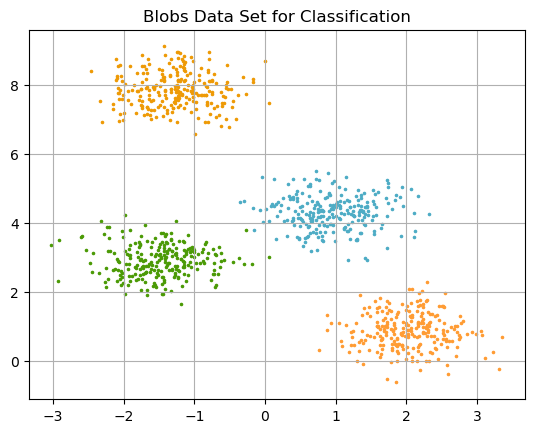

In [5]:
# Now for the graphical exploration....

plt.figure(1)
colors = ["#4EACC5", "#FF9C34", "#4B9A06", "#EE9A06","#5A1A06","#FAACC5", "#AF9C34","#A09A06"]

for k, col in enumerate(colors):
    cluster_data = Y_blobs1 == k
    plt.scatter(X_blobs[cluster_data, 0], X_blobs[cluster_data, 1], c=col, marker=".", s=10)

plt.title("Blobs Data Set for Classification")
plt.grid()
plt.show()

## Splitting the data: training, validation, and testing

The DIY version is fairly simple, just to show what is going on.....

In [25]:
# divide into training, validation, and testing data sets

def separate_data(X,Y,percent_validation=0.1,percent_test=0.1):

    N = len(X)
    len_validation = int(percent_validation*N)
    len_test = int(percent_test*N)
    len_train = N - len_validation - len_test

    len_t_v = len_train+len_validation

    X_train      = X[:len_train]
    Y_train      = Y[:len_train]
    X_validation = X[len_train:len_t_v]
    Y_validation = Y[len_train:len_t_v]
    X_test = X[len_t_v:]
    Y_test = Y[len_t_v:]  
    
    return (X_train,Y_train,X_validation,Y_validation,X_test,Y_test)

# tests

X_ = np.array(list(range(100)))
Y_ = np.array(list(range(100)))

separate_data(X_,Y_)
separate_data(X_,Y_,0.2,0.2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
        77, 78, 79]),
 array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
        77, 78, 79]),
 array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
        97, 98, 99]),
 array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
        97, 98, 99]))

In [7]:
X_train_blobs,Y_train_blobs,X_val_blobs,Y_val_blobs,X_test_blobs,Y_test_blobs = \
                                                                       separate_data(X_blobs,Y_blobs,0.1,0.2)

N_train,N_val,N_test = len(X_train_blobs),len(X_val_blobs),len(X_test_blobs)


print('X_train_blobs.size():',X_train_blobs.size())
print('Y_train_blobs.size():',Y_train_blobs.size())
print('X_val_blobs.size():  ',X_val_blobs.size())
print('Y_val_blobs.size():  ',Y_val_blobs.size())
print('X_test_blobs.size(): ',X_test_blobs.size())
print('Y_test_blobs.size(): ',Y_test_blobs.size())
print(X_test_blobs[0], Y_test_blobs[0])

X_train_blobs.size(): torch.Size([700, 2])
Y_train_blobs.size(): torch.Size([700])
X_val_blobs.size():   torch.Size([100, 2])
Y_val_blobs.size():   torch.Size([100])
X_test_blobs.size():  torch.Size([200, 2])
Y_test_blobs.size():  torch.Size([200])
tensor([-1.9306,  7.8245]) tensor(3)


## Defining a model in Pytorch

Pytorch is very "Pythonistic" in that it usually does things the natural way in Python. 
We will create a network (called a "model") using a class definition, which includes
some local variables, and a function called `forward` which will take an input vector, and send it through
the layers, returning the output at the end. 

Since we are trying to learn a classification of points into labels 0, 1, 2, 3, our input layer
must have 2 inputs, and our output layer will have 4 neurons. In between we can have any number
of neurons, but here we'll use 10. 

Thus, our network will have

    2 inputs for the (x,y) pairs:    one for each input
    10 neurons in the hidden layer
    4  neurons in the output layer:  one for each label for the 4-way classification task

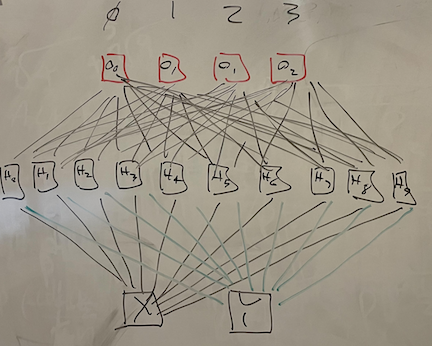

In [8]:
class BlobsModel(nn.Module):
    
        # We first define a number of local variables for layers
        
        def __init__(self):
            super(BlobsModel,self).__init__()
            self.hidden_layer1 = nn.Linear(2,10)     # 2 inputs connected to 10 neurons  
            
            self.hidden_layer2 = nn.Linear(10,4)     # 10 inputs connected to 4 neurons
         
        # foward defines the forward pass of a FFNN, 
        # sending a vector x through each layer and then returning it
 
        def forward(self,x):
            
            x = self.hidden_layer1(x)  
            x = F.sigmoid(x)                  # we have to explicitly send x through the sigmoid function   
            x = self.hidden_layer2(x)
                                              # we will take care of the softmax later
            return x



We needed to include the sigmoid explicitly in the forward function, but we did not
have to include a softmax, because the loss function we will use `CrossEntropyLoss` already
includes the softmax (this is done because, as shown in lecture, the derivative
of the combination of softmax and cross entropy is very simple, so they combine them). 

For a listing of various layers and functions you can use in `forward` see see:

https://pytorch.org/docs/stable/nn.html

## Running the Blobs Model

In order to run this model on the data, we need to do a couple of important things:

1. We must define the loss function;
2. We must specify an optimizer that will perform the gradient descent; there are many (see the link just given)
   and various parameters which you can set, including the learning rate. 
3. We must write a training loop which applies the model (actually, the forward function in the model) to the data
   and uses the loss function and optimizer. 

In [9]:
# first, create the model

blobs_model = BlobsModel()

print(blobs_model)

BlobsModel(
  (hidden_layer1): Linear(in_features=2, out_features=10, bias=True)
  (hidden_layer2): Linear(in_features=10, out_features=4, bias=True)
)


In [32]:
num_epoches = 100

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(blobs_model.parameters(),lr=0.1)
# optimizer = optim.Adam(blobs_model.parameters())
# optimizer = optim.Adagrad(blobs_model.parameters())
# optimizer = optim.RMSprop(blobs_model.parameters())

num_epochs = num_epoches

for epoch in tqdm(range(num_epochs)):           # for each epoch
    
    blobs_model.train()     # We are in training mode, so keep track of differentials for backtracking
    
    for k in range(len(X_train_blobs)):         # train the network on all the training data
        
        optimizer.zero_grad                     # reset the differentials to 0

        Y_hat = blobs_model(X_train_blobs[k])      # forward pass for this batch; Y_hat is output of network

        loss = loss_fn(Y_hat,Y_train_blobs[k])     # calculate the loss

        loss.backward()                         # do backpropagation to calculate the differentials 

        optimizer.step()                        # adjust parameters based on one step of gradient descent



100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.15it/s]


Now we can use our model to do predictions!  We'll add a softmax so we can see the probability
distribution being produced:

In [31]:
blobs_model(X_test_blobs[0])

tensor([ 42178.8125, -90286.2344,   6473.3281,  41701.0156],
       grad_fn=<AddBackward0>)

In [33]:
sm = nn.Softmax(dim=0)
    
def getPrediction(x):
    return torch.argmax(x).item()

for k in range(20):
    Y_hat = getPrediction(blobs_model(X_train_blobs[k]))
    print(f'{X_test_blobs[k]}\t{Y_test_blobs[k]}   {Y_hat}   {sm(blobs_model(X_test_blobs[k]))}')

tensor([-1.9306,  7.8245])	3   3   tensor([0., 0., 0., 1.], grad_fn=<SoftmaxBackward0>)
tensor([0.4536, 4.9094])	0   3   tensor([0., 0., 0., 1.], grad_fn=<SoftmaxBackward0>)
tensor([-1.4152,  7.8254])	3   3   tensor([0., 0., 0., 1.], grad_fn=<SoftmaxBackward0>)
tensor([-1.4262,  9.1056])	3   2   tensor([0., 0., 0., 1.], grad_fn=<SoftmaxBackward0>)
tensor([-1.6559,  8.7361])	3   1   tensor([0., 0., 0., 1.], grad_fn=<SoftmaxBackward0>)
tensor([1.3041, 0.0088])	1   3   tensor([0., 1., 0., 0.], grad_fn=<SoftmaxBackward0>)
tensor([2.1472, 0.7049])	1   3   tensor([0., 1., 0., 0.], grad_fn=<SoftmaxBackward0>)
tensor([-1.7356,  2.3691])	2   1   tensor([0., 0., 1., 0.], grad_fn=<SoftmaxBackward0>)
tensor([1.7071, 0.7525])	1   3   tensor([0., 1., 0., 0.], grad_fn=<SoftmaxBackward0>)
tensor([-1.0268,  7.9447])	3   3   tensor([0., 0., 0., 1.], grad_fn=<SoftmaxBackward0>)
tensor([-1.7824,  3.3052])	2   3   tensor([0., 0., 1., 0.], grad_fn=<SoftmaxBackward0>)
tensor([0.3499, 4.6925])	0   1   tensor(

## Testing the Blobs Model

In order to find out precisely how accurate our model is, let's add a final phase where we
run the data from our testing set through the model and check what percentage of the
testing data was identified correctly. 

In [38]:
blobs_model = BlobsModel()

# print(blobs_model)

loss_fn = nn.CrossEntropyLoss()

# optimizer = optim.SGD(blobs_model.parameters(),lr=0.0001)
# optimizer = optim.Adam(blobs_model.parameters())
optimizer = optim.Adagrad(blobs_model.parameters(),lr=0.01)
# optimizer = optim.RMSprop(blobs_model.parameters(),lr=0.001)

num_epochs = 100

for epoch in tqdm(range(num_epochs)):           # for each epoch
        
    blobs_model.train()                     # We are in training mode, so keep track of differentials for backtracking
    
    for k in range(len(X_train_blobs)):         # train the network on all the training data
        
        optimizer.zero_grad                     # reset the differentials to 0

        Y_hat = blobs_model(X_train_blobs[k])      # forward pass for this batch; Y_hat is output of network

        loss = loss_fn(Y_hat,Y_train_blobs[k])     # calculate the loss

        loss.backward()                         # do backpropagation to calculate the differentials 

        optimizer.step()                        # adjust parameters based on one step of gradient descent


blobs_model.eval()          # stop doing backprob, just run model as feed-forward phase
num_correct_test = 0

for k in range(len(X_test_blobs)):  

    Y_hat_test = blobs_model(X_test_blobs[k])
    if getPrediction(Y_hat_test) == Y_test_blobs[k]:
        num_correct_test += 1   

test_accuracy = num_correct_test / len(X_test_blobs)
    
print("Accuracy:", test_accuracy )

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.88it/s]

Accuracy: 0.995


## Validating and Tracking Performance during Training

In order to see what is actually happening during the training phase, we will
add a validation phase at the end of each epoch, running the same testing
code as above, but on the validation set. In addition, we will collect
information about the cumulative loss during each epoch and report all these
in graphical form. 

In [15]:
def show_performance_curves(training_loss,validation_loss,training_accuracy,validation_accuracy,test_accuracy):

    plt.figure(figsize=(5, 3))
    plt.plot(training_loss,label='Training',color='g')
    plt.plot(validation_loss,label='Validation',color='b')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
#     plt.ylim(-0.1,(max(max(training_loss),max(validation_loss))*1.1) )
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    
    print('Final Training Loss:  ',np.around(training_loss[-1],6))
    print('Final Validation Loss:',np.around(validation_loss[-1],6))
    
    plt.figure(figsize=(5, 3))
    plt.plot(training_accuracy,label='Training',color='g')
    plt.plot(validation_accuracy,label='Validation',color='b')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
#     plt.ylim(-0.1,1.1)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    
    print('Final Training Accuracy:  ',np.around(training_accuracy[-1],6))
    print('Final Validation Accuracy:',np.around(validation_accuracy[-1],6))
    print()
    
    print("Test Accuracy:", np.around(test_accuracy.item(),4))

    print()

100%|█████████████████████████████████████████| 100/100 [00:29<00:00,  3.41it/s]


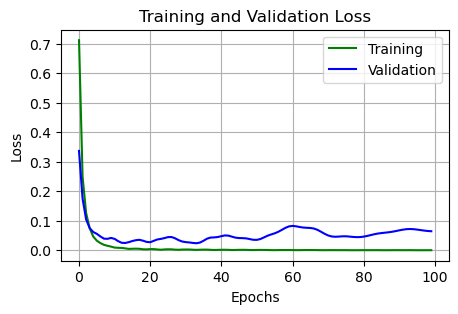

Final Training Loss:   0.000247
Final Validation Loss: 0.064506


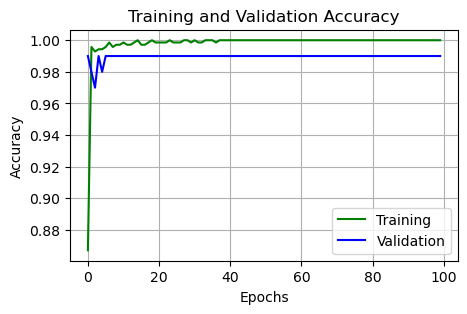

Final Training Accuracy:   1.0
Final Validation Accuracy: 0.99

Test Accuracy: 0.99



In [45]:
blobs_model = BlobsModel()

# print(blobs_model)

loss_fn = nn.CrossEntropyLoss()

# optimizer = optim.SGD(blobs_model.parameters(),lr=0.0001)
# optimizer = optim.Adam(blobs_model.parameters())
optimizer = optim.Adagrad(blobs_model.parameters())
# optimizer = optim.RMSprop(blobs_model.parameters(),lr=0.001)

num_epochs = 100

training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

for epoch in tqdm(range(num_epochs)):           # for each epoch
 
    blobs_model.train()                     # We are in training mode, so keep track of differentials for backtracking
    t_loss = 0.0
    t_num_correct = 0
    
    for k in range(len(X_train_blobs)):         # train the network on all the training data 

        optimizer.zero_grad                     # reset the differentials to 0

        Y_hat = blobs_model(X_train_blobs[k])      # forward pass for this batch; Y_hat is output of network

        loss = loss_fn(Y_hat,Y_train_blobs[k])     # calculate the loss

        loss.backward()                         # do backpropagation to calculate the differentials 

        optimizer.step()                        # adjust parameters based on one step of gradient descent
        
        t_loss += loss.item()                   # total up the losses for each epoch
        
        # If we just use the scalar class number, it must be a long (we did this when creating the dataset)
        
        t_num_correct += (torch.argmax(Y_hat) == Y_train_blobs[k]).float().sum()
    
    training_losses[epoch]   = t_loss/len(X_train_blobs)
    training_accuracy[epoch] = t_num_correct/len(X_train_blobs)
    
    #  validation
    v_loss = 0.0
    blobs_model.eval()      # don't track differentials
    v_num_correct = 0
    
    for k in range(len(X_val_blobs)):   
        Y_hat_val = blobs_model(X_val_blobs[k])
        loss = loss_fn(Y_hat_val,Y_val_blobs[k])
        v_loss += loss.item() 
        
        v_num_correct += (torch.argmax(Y_hat_val) == Y_val_blobs[k]).float().sum() 

    val_losses[epoch]   = v_loss/len(X_val_blobs)
    val_accuracy[epoch] = v_num_correct/len(X_val_blobs)

num_correct_test = 0
blobs_model.eval()


for k in range(len(X_test_blobs)):  

    Y_hat_test = blobs_model(X_test_blobs[k])
    if torch.argmax(Y_hat_test) == Y_test_blobs[k]:
        num_correct_test += 1   

test_accuracy = torch.tensor(num_correct_test / len(X_test_blobs))

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy)    



## Batching the Data

In order to take advantage of GPU's parallelism, just about anything you can do with a single data
sample you can do with an array of such samples, called a **batch**. 

Batching also tends to improve gradient descent, and basically all serious NN implementations use
batching. Batch size can vary, but is often in the range of 64 - 256 (best as a power of 2). 

Here is a DIY batch processing version of our code. 

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 115.51it/s]


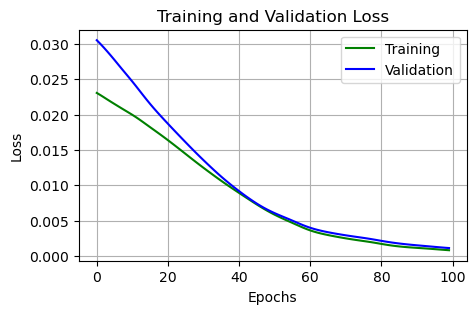

Final Training Loss:   0.000802
Final Validation Loss: 0.00111


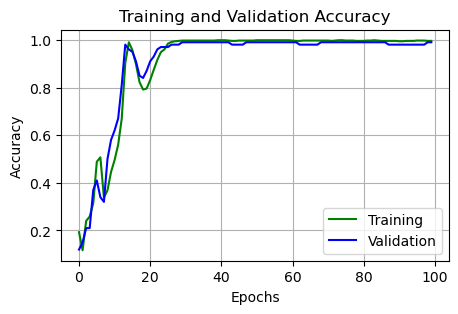

Final Training Accuracy:   0.995714
Final Validation Accuracy: 0.99

Test Accuracy: 0.995



In [46]:
blobs_model = BlobsModel()

# print(blobs_model)

loss_fn = nn.CrossEntropyLoss()

# optimizer = optim.SGD(blobs_model.parameters(),lr=0.001)
optimizer = optim.Adam(blobs_model.parameters(),lr=0.001)
# optimizer = optim.Adagrad(blobs_model.parameters(),lr=0.01)
# optimizer = optim.RMSprop(blobs_model.parameters(),lr=0.001)

num_epochs = 100

batch_size = 64

training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

for epoch in tqdm(range(num_epochs)):
    # training
    blobs_model.train()     # keep track of differentials
    t_loss = 0.0
    t_num_correct = 0
    
    for k in range(int(np.ceil(len(X_train_blobs)/batch_size))):  
        lo = k * batch_size
        hi = lo + batch_size
        X_batch = X_train_blobs[lo:hi]          # no problem if hi is past end of array 
        Y_batch = Y_train_blobs[lo:hi]
        
        optimizer.zero_grad               # reset the differentials to 0
        Y_hat = blobs_model(X_batch)      # forward pass for this batch
        loss = loss_fn(Y_hat,Y_batch)     # calculate the loss
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        
        # If we just use the scalar class number, it must be a long (we did this when creating the dataset)
        t_num_correct += (torch.argmax(Y_hat,dim=1) == Y_batch).float().sum()
    
    training_losses[epoch]   = t_loss/len(X_train_blobs)
    training_accuracy[epoch] = t_num_correct/len(X_train_blobs)
    
    #  validation
    v_loss = 0.0
    blobs_model.eval()      # don't track differentials
    v_num_correct = 0
    
    for k in range(int(np.ceil(len(X_val_blobs)/batch_size))):  
        lo = k * batch_size
        hi = lo + batch_size
        X_val_batch = X_val_blobs[lo:hi]          # no problem if hi is past end of array 
        Y_val_batch = Y_val_blobs[lo:hi]
        
        Y_hat_val = blobs_model(X_val_batch)
        loss = loss_fn(Y_hat_val,Y_val_batch)
        v_loss += loss.item() 
        
        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == Y_val_batch).float().sum() 

    val_losses[epoch]   = v_loss/len(X_val_blobs)
    val_accuracy[epoch] = v_num_correct/len(X_val_blobs)
    
#  testing
num_correct_test = 0
blobs_model.eval()
    
for k in range(int(np.ceil(len(X_test_blobs)/batch_size))):  
    lo = k * batch_size
    hi = lo + batch_size
    X_test_batch = X_test_blobs[lo:hi]          # no problem if end_i is past end of array 
    Y_test_batch = Y_test_blobs[lo:hi]

    Y_hat_batch = blobs_model(X_test_batch)
    num_correct_test += (torch.argmax(Y_hat_batch,dim=1) == Y_test_batch).float().sum()   

test_accuracy = num_correct_test / len(X_test_blobs)
    
show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy)    


## Pytorch Datasets and Dataloaders

Often, you can download preprocessed data sets all ready to manipulate with Pytorch.
However, here we'll show you how they work by putting together a dataset and dataloader
for the Blobs dataset.

The two things that a dataloader gives you are:

1. It automatically batches the data in such a way that you can simply give your model a batch
   of data, and it will do them all in parallel if you are running on a GPU. 
2. It combines the data and labels so you don't have to treat them separately. 

The dataloader needs a dataset to load, so we'll do that first. 


In [19]:
from sklearn.datasets import make_blobs
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class BlobsDataset(Dataset):
    
    def __init__(self, X,Y):  
        self.X_blobs = X
        self.Y_blobs = Y 

    def __len__(self):
        return len(self.X_blobs)

    # return a pair x,y at the index idx in the data set
    def __getitem__(self, idx):
        return self.X_blobs[idx], self.Y_blobs[idx]
    

## Shuffling and Splitting your data

We will also use the PyTorch data utility `random_split` instead of our homegrown `separate_data`.  

In [20]:

batch_size = 64

blobs_ds = BlobsDataset(X_blobs,Y_blobs)

gen = torch.Generator().manual_seed(0)  # this will ensure the same split every time

train_blobs_ds,val_blobs_ds,test_blobs_ds = random_split(blobs_ds, [0.7,0.1,0.2], generator=gen)

blobs_training_dataloader =   DataLoader(train_blobs_ds, batch_size=batch_size, shuffle=True)

blobs_validation_dataloader = DataLoader(val_blobs_ds,   batch_size=batch_size, shuffle=True)

blobs_testing_dataloader =    DataLoader(test_blobs_ds,  batch_size=batch_size, shuffle=True)


The dataloader is an iterable which can be used in a for loop to provide one batch at a time

In [21]:

for x,y in blobs_training_dataloader:
    print(x)
    print(y)
    break

tensor([[-1.2556e+00,  3.2759e+00],
        [-1.1509e+00,  3.1994e+00],
        [-3.1933e-02,  4.0341e+00],
        [-1.1611e+00,  2.8851e+00],
        [ 1.8993e+00,  4.7752e-01],
        [ 2.0276e+00,  7.6569e-01],
        [-1.6466e+00,  2.7945e+00],
        [-1.3574e+00,  2.6231e+00],
        [ 1.8699e+00,  4.2486e-01],
        [-1.8067e+00,  7.8178e+00],
        [ 2.0478e+00,  1.3084e+00],
        [ 8.7318e-01,  9.0783e-01],
        [ 1.3328e+00,  2.9239e-01],
        [ 3.8184e-01,  4.0504e+00],
        [-1.4962e+00,  8.4437e+00],
        [-4.0350e-03,  8.6834e+00],
        [-1.9269e+00,  2.8078e+00],
        [ 2.5235e+00,  6.3484e-01],
        [-1.7686e+00,  7.6777e+00],
        [-1.2070e+00,  7.4247e+00],
        [ 2.4168e+00,  9.0997e-01],
        [-1.5436e+00,  2.1525e+00],
        [-1.7436e+00,  7.3341e+00],
        [ 4.7616e-01,  3.5314e+00],
        [-1.6428e+00,  7.8361e+00],
        [ 1.6556e+00,  1.0181e+00],
        [ 1.4410e+00,  4.5949e+00],
        [-1.4005e+00,  2.713

In [22]:
lim = 10
for x,y in blobs_training_dataloader:
    print(x.shape,y.shape)
    lim -= 1
    if lim < 1:
        break

torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])


## Blobs Model using Dataloader

100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 60.23it/s]


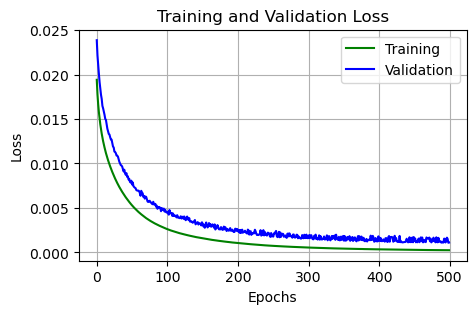

Final Training Loss:   0.00025
Final Validation Loss: 0.001112


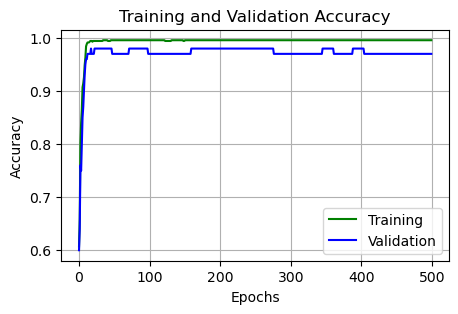

Final Training Accuracy:   0.995714
Final Validation Accuracy: 0.97

Test Accuracy: 1.0



In [49]:
blobs_model2 = BlobsModel()

# print(blobs_model)

loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(blobs_model2.parameters(),lr=0.001)
# optimizer = optim.Adam(blobs_model2.parameters())
optimizer = optim.Adagrad(blobs_model2.parameters(),lr=0.01)
# optimizer = optim.RMSprop(blobs_model2.parameters(),lr=0.001)

num_epochs = 500

batch_size = 64

training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

for epoch in tqdm(range(num_epochs)):
    # training
    blobs_model2.train()
    t_loss = 0.0
    t_num_correct = 0
    
    for X_train_batch,Y_train_batch in blobs_training_dataloader:
        
        optimizer.zero_grad
        Y_train_hat = blobs_model2(X_train_batch)
        loss = loss_fn(Y_train_hat,Y_train_batch)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        
        # If we just use the scalar class number, it must be a long (we did this when creating the dataset)
        t_num_correct += (torch.argmax(Y_train_hat,dim=1) == Y_train_batch).float().sum()
    
    training_losses[epoch]   = t_loss/N_train
    training_accuracy[epoch] = t_num_correct/N_train
    
    #  validation
    v_loss = 0.0
    blobs_model2.eval()
    v_num_correct = 0
    
    for X_val_batch,Y_val_batch in blobs_validation_dataloader:

        Y_hat_val = blobs_model2(X_val_batch)
        loss = loss_fn(Y_hat_val,Y_val_batch)
        v_loss += loss.item() 
        
        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == Y_val_batch).float().sum() 

    val_losses[epoch]   = v_loss/N_val
    val_accuracy[epoch] = v_num_correct/N_val
    
#  testing
num_correct_test = 0
blobs_model2.eval()
    
for X_test_batch,Y_test_batch in blobs_testing_dataloader:
    Y_hat_test = blobs_model2(X_test_batch)
    num_correct_test += (torch.argmax(Y_hat_test,dim=1) == Y_test_batch).float().sum()   

test_accuracy = num_correct_test / N_test
    
show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy)    


## Using a GPU

In order to use the GPU in Collab or elsewhere, we need to move the model
and the data it operates on to the GPU, if available. 

Here is the previous code adapted for this purpose. 

Using cpu



100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 75.03it/s]


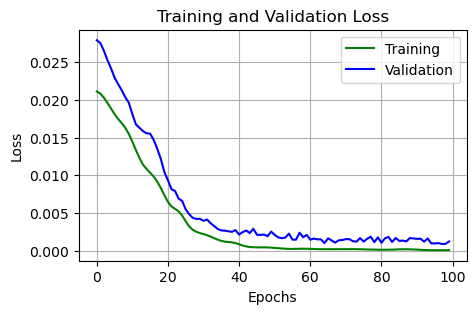

Final Training Loss:   7.7e-05
Final Validation Loss: 0.001227


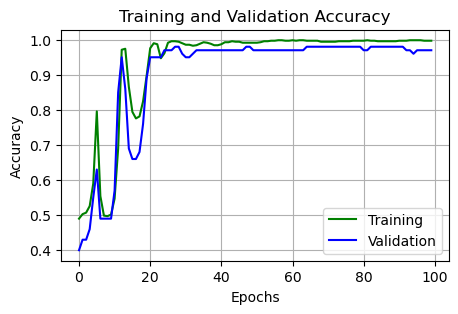

Final Training Accuracy:   0.997143
Final Validation Accuracy: 0.97

Test Accuracy: 1.0



In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")
print()


blobs_model2 = BlobsModel().to(device)                     # <<====

# print(blobs_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(blobs_model2.parameters(),lr=0.001)
# optimizer = optim.Adam(blobs_model2.parameters(),lr=0.001)
# optimizer = optim.Adagrad(blobs_model2.parameters(),lr=0.01)
# optimizer = optim.RMSprop(blobs_model2.parameters(),lr=0.001)

num_epochs = 100

batch_size = 64

training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

for epoch in tqdm(range(num_epochs)):
    # training
    blobs_model2.train()
    t_loss = 0.0
    t_num_correct = 0
    
    for X_train_batch,Y_train_batch in blobs_training_dataloader:
        X_train_batch = X_train_batch.to(device)                     # <<====
        Y_train_batch = Y_train_batch.to(device)                     # <<====
        
        optimizer.zero_grad
        Y_train_hat = blobs_model2(X_train_batch)
        loss = loss_fn(Y_train_hat,Y_train_batch)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        
        # If we just use the scalar class number, it must be a long (we did this when creating the dataset)
        t_num_correct += (torch.argmax(Y_train_hat,dim=1) == Y_train_batch).float().sum()
    
    training_losses[epoch]   = t_loss/N_train
    training_accuracy[epoch] = t_num_correct/N_train
    
    #  validation
    v_loss = 0.0
    blobs_model2.eval()
    v_num_correct = 0
    
    for X_val_batch,Y_val_batch in blobs_validation_dataloader:
        X_val_batch = X_val_batch.to(device)                     # <<====
        Y_val_batch = Y_val_batch.to(device)                     # <<====
        
        Y_hat_val = blobs_model2(X_val_batch)
        loss = loss_fn(Y_hat_val,Y_val_batch)
        v_loss += loss.item() 
        
        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == Y_val_batch).float().sum() 

    val_losses[epoch]   = v_loss/N_val
    val_accuracy[epoch] = v_num_correct/N_val
    
#  testing
num_correct_test = 0
blobs_model2.eval()
    
for X_test_batch,Y_test_batch in blobs_testing_dataloader:
    X_test_batch = X_test_batch.to(device)                     # <<====
    Y_test_batch = Y_test_batch.to(device)                     # <<====
        
    Y_hat_test = blobs_model2(X_test_batch)
    
    num_correct_test += (torch.argmax(Y_hat_test,dim=1) == Y_test_batch).float().sum()   

test_accuracy = num_correct_test / N_test
    
show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy)    
